In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from scipy.stats import spearmanr, ttest_1samp, binned_statistic
from settings import (colors, titles, ax_label_size, tick_label_size,
                      letter_size, legend_size, lw, line_alpha, fill_alpha)
from settings import (plot_lower, plot_upper, stats_frac_lower,
                      stats_frac_upper, select_lower, select_upper,
                      p_lower, p_upper, stats_frac_middle,
                      ci, title_pad)

In [2]:
ccycle = mplego.colors.get_default_ccycle()

In [3]:
exp = 10
loc = 'data'
loc = 'noise_correlations'

In [4]:
base_path = f"/storage/noise_correlations/exp{exp}"
pvc11_1_rpath = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
pvc11_2_rpath = os.path.join(base_path, f'exp{exp}_2_pvc11_20_1000_1000.h5')
pvc11_3_rpath = os.path.join(base_path, f'exp{exp}_3_pvc11_20_1000_1000.h5')

In [7]:
# PVC11 paths
base_path = f"/storage/noise_correlations"
pvc11_1_path = os.path.join(base_path, 'pvc11/data/spikes_gratings/data_monkey1_gratings.mat')
pvc11_2_path = os.path.join(base_path, 'pvc11/data/spikes_gratings/data_monkey2_gratings.mat')
pvc11_3_path = os.path.join(base_path, 'pvc11/data/spikes_gratings/data_monkey3_gratings.mat')
# Create neuropacks
pvc11_1 = packs.PVC11(data_path=pvc11_1_path)
pvc11_2 = packs.PVC11(data_path=pvc11_2_path)
pvc11_3 = packs.PVC11(data_path=pvc11_3_path)
# Load response matrices
X_pvc11_1 = pvc11_1.get_response_matrix(transform=None)
X_pvc11_2 = pvc11_2.get_response_matrix(transform=None)
X_pvc11_3 = pvc11_3.get_response_matrix(transform=None)
# Extract stimuli
stimuli_pvc11 = pvc11_1.get_design_matrix(form='angle')

In [9]:
X_pvc11_1.mean(), X_pvc11_2.mean(), X_pvc11_3.mean()

(6.420200471698113, 3.8307859848484846, 7.983634672619048)

In [35]:
pvc11_1 = h5py.File(pvc11_1_rpath, 'r')
pvc11_2 = h5py.File(pvc11_2_rpath, 'r')
pvc11_3 = h5py.File(pvc11_3_rpath, 'r')
results = [pvc11_1, pvc11_2, pvc11_3]

n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [40]:
groups = [
    'v_lfi',
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
labels = [
    'Observed',
    'Shuffle',
    'UC',
    'FA'
]

percentile_groups = [
    'p_s_lfi',
    'p_u_lfi',
    'p_fa_lfi'
]
value_groups = [
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
lfi_models = [
    'observed',
    'shuffle',
    'uniform',
    'fa'
]
models = [
    'shuffle',
    'uniform',
    'fa'
]
labels2 = [
    'Shuffle',
    'UC',
    'FA'
]
pvc_colors = ['black', 'red', 'blue']
titles = ['V1 1', 'V1 2', 'V1 3']

T = np.array([200, 200, 200])[:, np.newaxis]
N = dims[np.newaxis]
dtheta = np.array([np.mean(np.diff(np.unique(pvc11_1['stimuli'][:]))),
                   np.mean(np.diff(np.unique(pvc11_2['stimuli'][:]))),
                   np.mean(np.diff(np.log(np.unique(pvc11_3['stimuli'][:]))))])[:, np.newaxis]
c0s = (2. * T - N - 3.) / (2. * T - 2)
c1s = (2. * N) / (T * dtheta**2)

In [36]:
median_lfis = dict()
for idx, (result, c0, c1) in enumerate(zip(results, c0s, c1s)):
    c0 = c0[:, np.newaxis]
    c1 = c1[:, np.newaxis]
    # Plot observed LFI
    for group, model in zip(groups, lfi_models):
        if group == 'v_lfi':
            median_lfis[(idx, group)] = result[group][:] * c0 - c1
        else:
            median_lfis[(idx, group)] = np.median(result[group], axis=2) * c0 - c1
            # Alternative: take statistics across all dim-stims and repeats
            # values = np.reshape(result[group], (dims.size, -1))

In [37]:
lmus_lfi = dict()
lmus_p = dict()
for idx in range(len(results)):
    print(idx)
    # Plot observed LFI
    for group in groups:
        values = median_lfis[(idx, group)]
        lmus_lfi[(idx, group)] = utils.run_bootstrap(values, np.median, ci).T
        
    for group in percentile_groups:
        # Calculate median and bounds for each null model
        percentiles = results[idx][group][:]
        lmus_p[(idx, group)] = utils.run_bootstrap(percentiles, np.median, ci).T

0
1
2


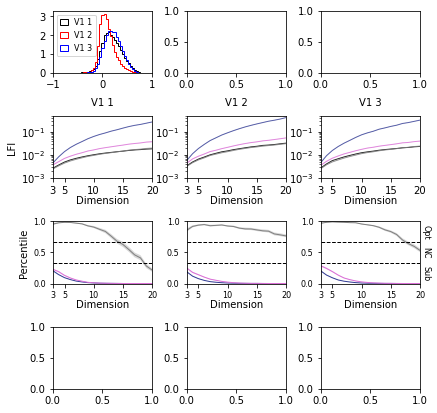

In [41]:
fig = plt.figure(figsize=(6, 6))

le = .1
re = .05
be = .075
te = .05
hg = .08
vg = .1
h = (1. - te - be - 3*vg) / 4.
w = (1. - le - re - 2*hg) / 3.
axes = np.empty((4, 3), dtype=object)
for ii in range(4):
    for jj in range(3):
        axes[ii, jj] = fig.add_axes([le + jj*(w + hg),
                                     be + (3-ii)*(h + vg),
                                     w, h])
ax = axes[0, 0]
# Calculate distribution of noise correlations
nc_pvc11_1 = analysis.all_correlations(X_pvc11_1, stimuli_pvc11)
nc_pvc11_2 = analysis.all_correlations(X_pvc11_2, stimuli_pvc11)
nc_pvc11_3 = analysis.all_correlations(X_pvc11_3, stimuli_pvc11)
ncs = [nc_pvc11_1, nc_pvc11_2, nc_pvc11_3]
# Plot distributions as density histograms
bins = np.linspace(-1, 1, 50)
for ii, nc in enumerate(ncs):
    ax.hist(nc, bins=bins, density=True, color=pvc_colors[ii], histtype='step', linewidth=1., label=titles[ii])
ax.legend(loc='upper left', fontsize=legend_size, handlelength=1.)
ax.set_yticks([0, 1, 2, 3])
ax.set_xticks([-1, 0, 1])
ax.set_xlim(-1, 1)

"""
Second row: LFI values over dimension
"""
# Enumerate over results
for idx, (result, ax) in enumerate(zip(results, axes[1])):
    # Plot observed LFI
    for group, model in zip(groups, lfi_models):
        color = colors[model]
        lower, median, upper = lmus_lfi[(idx, group)]
        # Fill region between percentile bounds
        ax.fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=color,
            alpha=fill_alpha,
            ec='none')
        ax.plot(
            dims,
            median,
            linewidth=lw,
            color=color,
            alpha=line_alpha)

# Set axis limits, scales, and labels
for (ax, title) in zip(axes[1], titles):
    ax.set_xlim([3, 20])
    ax.set_yscale('log')
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_ylim(1e-3, 5e-1)
    
    ax.set_xlabel(r'Dimension', fontsize=ax_label_size, labelpad=0)
    ax.set_title(title, fontsize=ax_label_size, pad=title_pad)
axes[1, 0].set_ylabel(r'LFI', fontsize=ax_label_size)

"""
Third Row: percentiles
"""
# Enumerate over results
for idx, result in enumerate(results):
    # Iterate over null models
    for group, model in zip(percentile_groups, models):
        # Calculate median and bounds for each null model
        lower, median, upper = lmus_p[(idx, group)]
        # Fill region between percentile bounds
        axes[2, idx].fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=colors[model],
            alpha=fill_alpha,
            ec='none')
        axes[2, idx].plot(
            dims,
            median,
            linewidth=lw,
            color=colors[model])
    axes[2, idx].axhline(plot_lower, 0, 1, lw=lw, ls='--', c='k')
    axes[2, idx].axhline(plot_upper, 0, 1, lw=lw, ls='--', c='k')
        
axes[2, 2].text(21, 5/6, 'Opt', va='center', ha='center', rotation=-90, fontsize=tick_label_size)
axes[2, 2].text(21, 3/6, 'NC', va='center', ha='center', rotation=-90, fontsize=tick_label_size)
axes[2, 2].text(21, 1/6, 'Sub', va='center', ha='center', rotation=-90, fontsize=tick_label_size)

# Set axis limits, scales, and labels
for ax in axes[2]:
    ax.set_xlim([3, 20])
    ax.set_ylim([0, 1])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([0, .5, 1])
    ax.tick_params(labelsize=tick_label_size)
    
    ax.set_xlabel('Dimension', fontsize=ax_label_size, labelpad=0)
axes[2, 0].set_ylabel('Percentile', fontsize=ax_label_size)



plt.savefig('supp6.pdf', dpi=300)
plt.savefig('supp6.jpg', dpi=300)